In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib as mpl 
import matplotlib.pyplot as plt
from tqdm import tqdm # Execution progress
import numpy as np

# Torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset

# sci-kit learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Others
from mlxtend.plotting import plot_confusion_matrix
from IPython.core.debugger import set_trace
import re

## Data loading and enviroment preparation

In [2]:
# GPU as device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Connectamos la sesión a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data loading via drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/data_v2.csv', index_col = 0)
df_flag = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/data_flag_v2.csv', index_col = 0)

In [5]:
# Cambiamos la nomenclarutra de los clientes a one hote encoding para poder hacer indexar el dataframe
df2, df_flag2 = sklearn.utils.shuffle(df, df_flag, random_state=0, n_samples=None)
df_flag2.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/df_flag_shuffled.csv')
aux = np.linspace(0,len(df)-1,len(df)).astype(int).tolist()
df2 = df2.T
df2.columns = aux
df2 = df2.T

df_flag2 = df_flag2.T
df_flag2.columns = aux
df_flag2 = df_flag2.T

# WIDE Net

Epoch 1
----------------------------
TRAIN LOSS: 4.797556028915204
TEST METRICS: 4.556254132659034 0.6382819386791582
Epoch 2
----------------------------
TRAIN LOSS: 4.399309156531623
TEST METRICS: 4.4875532160114755 0.6686956659647821
Epoch 3
----------------------------
TRAIN LOSS: 4.33378061923945
TEST METRICS: 4.477474362449309 0.6844473731266184
Epoch 4
----------------------------
TRAIN LOSS: 4.242760374872622
TEST METRICS: 4.414959933202176 0.7076102592487895
Epoch 5
----------------------------
TRAIN LOSS: 4.13902402565951
TEST METRICS: 4.43552776599704 0.6838174372931077
Epoch 6
----------------------------
TRAIN LOSS: 4.149819850234974
TEST METRICS: 4.492637492210816 0.6600114571812685
Epoch 7
----------------------------
TRAIN LOSS: 4.065987740824081
TEST METRICS: 4.51068529337205 0.665853678515049
Epoch 8
----------------------------
TRAIN LOSS: 4.06569605741852
TEST METRICS: 4.4833414410419525 0.667636826524612
Epoch 9
----------------------------
TRAIN LOSS: 4.0162406749

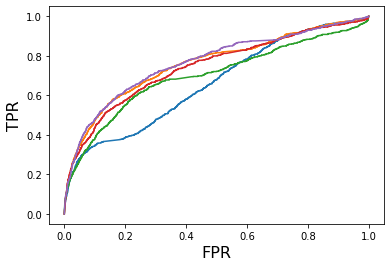

<Figure size 432x288 with 0 Axes>

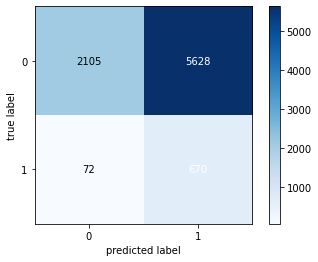

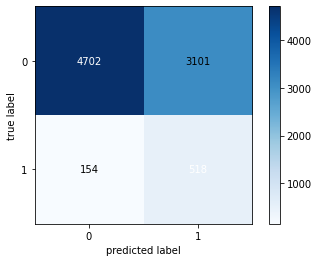

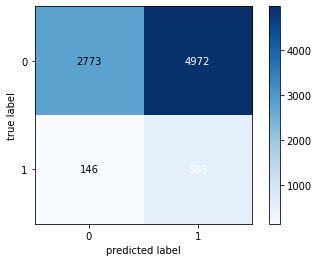

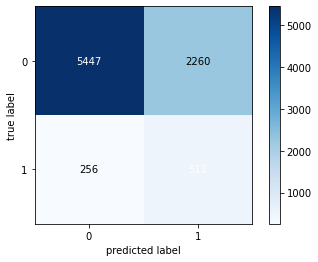

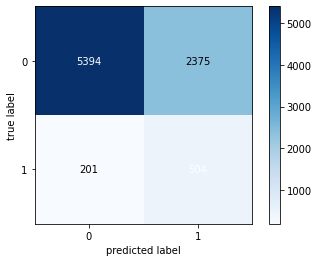

In [22]:
# Cross validation
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from modelos import WideNet
from funciones import train, test_inference, test_validate, normalizacion

kf = KFold(n_splits=5)
k = 1
ps_test=[]
ys_test=[]

model_WIDE = WideNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 100
batch_size = 64
# Traing diferents optimizers
optimizer = torch.optim.SGD(model_WIDE.parameters(), lr=1e-1) # Stochastic gradient descent
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, betas=(0.9, 0.999)) 
# optimizer = torch.optim.Adadelta(model.parameters(), lr=1e-1, rho=0.9, eps=1e-06, weight_decay=0)

for train_index, test_index in kf.split(df2, df_flag2):  
    # print(train_index, test_index)

    x_train_fold = df2.T[train_index] 
    y_train_fold = df_flag2.T[train_index] 
    x_test_fold = df2.T[test_index] 
    y_test_fold = df_flag2.T[test_index] 

    x_train_fold = x_train_fold.T
    y_train_fold = y_train_fold.T
    x_test_fold = x_test_fold.T 
    y_test_fold = y_test_fold.T 

    # print(x_train_fold.shape, y_train_fold.shape) 
    # print(x_test_fold.shape, y_test_fold.shape)

    # Data normalitzation (desv estandard and consumer mean)
    df_train_norm, df_test_norm, df_flag_train, df_flag_test = normalizacion (x_train_fold, x_test_fold, y_train_fold, y_test_fold)

    train_ds_wide = TensorDataset(df_train_norm, df_flag_train)
    test_ds_wide = TensorDataset(df_test_norm, df_flag_test)

    # DataLoader 
    train_dataloader_wide = DataLoader(train_ds_wide, batch_size=batch_size)
    test_dataloader_wide = DataLoader(test_ds_wide, batch_size=batch_size)

    # Entrenamiento y metrias
    for t in range(epochs):
      print(f"Epoch {t+1}\n----------------------------")
      train(train_dataloader_wide, model_WIDE, loss_fn, optimizer)
      test_validate(test_dataloader_wide, model_WIDE)
    print ("Fin")

    # ROC - AUC
    print(f"Fold {k}----------------------------")
    ps, ys = test_inference(test_dataloader_wide,model_WIDE)
    auc = sklearn.metrics.roc_auc_score(ys,ps)
    print("ROC-AUC =", auc)
    # Gráfica ROC - AUC
    fpr, tpr, thresholds = sklearn.metrics.roc_curve (ys,ps)
    plt.figure(0)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR", size = 16,)
    plt.ylabel("TPR", size = 16)
    # Guardamos las prediciones de test para cada fold
    ps_df = pd.DataFrame(ps.numpy())
    ps_test.append(ps_df)
    # ps_test += ps_df
    ys_df = pd.DataFrame(ys.numpy())
    ys_test.append(ys_df)
    # ys_test += ys

    # Matriz de confusión
    cf = sklearn.metrics.confusion_matrix(ys,(ps>0.04))
    tn, fp, fn, tp = confusion_matrix(ys,(ps>0.04)).ravel()
    print("SENSITIVITY =", 100*tp/(tp+fn))
    print("SPECIFICITY =", 100*tn/(tn+fp))
    plt.figure(1)
    plot_confusion_matrix(conf_mat = cf, colorbar = 1)

    model_WIDE = WideNet().to(device)
    optimizer = torch.optim.SGD(model_WIDE.parameters(), lr=1e-1)

    k = k + 1


In [24]:
ps_testu = pd.concat([ps_test[0],ps_test[1],ps_test[2],ps_test[3],ps_test[4]])
ys_testu = pd.concat([ys_test[0],ys_test[1],ys_test[2],ys_test[3],ys_test[4]])

In [27]:
# Guardamos las prediciones en csv
# ps_test_df = pd.DataFrame(ps_test)
# ys_test_df = pd.DataFrame(ys_test)
ps_testu.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/ps_testu_WIDE.csv')
ys_testu.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/ys_testu.csv')

# CNN Net

Epoch 1
----------------------------
TRAIN LOSS: 8.592645842462746
TEST METRICS: 6.40116450005928 0.3696078137488267
Epoch 2
----------------------------
TRAIN LOSS: 5.314132036313683
TEST METRICS: 4.838420344313338 0.548316923689317
Epoch 3
----------------------------
TRAIN LOSS: 4.505400768195921
TEST METRICS: 4.521356293585448 0.6193215584973281
Epoch 4
----------------------------
TRAIN LOSS: 4.406141700291172
TEST METRICS: 4.497719234773191 0.6316089235652294
Epoch 5
----------------------------
TRAIN LOSS: 4.380563243418685
TEST METRICS: 4.482813646308089 0.6404728152493793
Epoch 6
----------------------------
TRAIN LOSS: 4.360985356498778
TEST METRICS: 4.470308754472255 0.647881031446076
Epoch 7
----------------------------
TRAIN LOSS: 4.345036045199957
TEST METRICS: 4.459127456740995 0.6544393701791914
Epoch 8
----------------------------
TRAIN LOSS: 4.331366562548262
TEST METRICS: 4.4496909583916 0.6574443096290167
Epoch 9
----------------------------
TRAIN LOSS: 4.3193242175

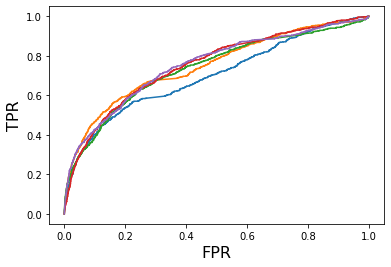

<Figure size 432x288 with 0 Axes>

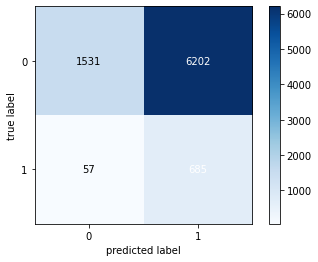

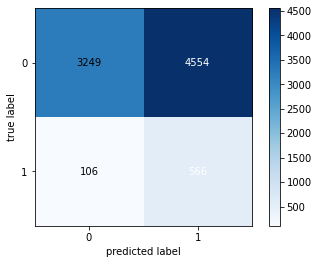

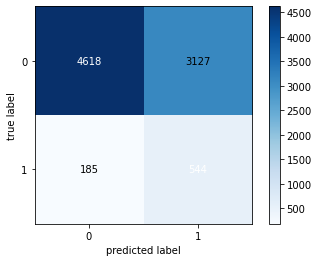

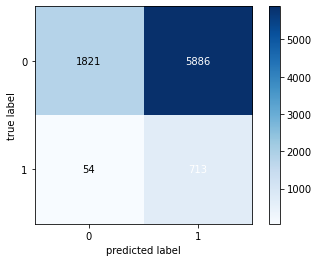

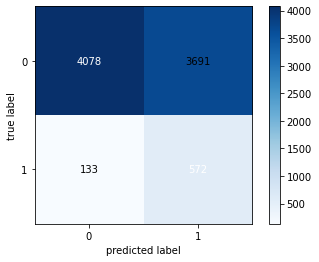

In [29]:
# Cross validation
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from modelos import CNNNet
from funciones import train, test_inference, test_validate, normalizacion
from dataset_f import g1, g2, CNNDataset, CNNDataset_func

k = 1
kf = KFold(n_splits=5)
ps_test=[]
ps_test2=[]

loss_fn = nn.BCEWithLogitsLoss()
model_CNN = CNNNet().to(device)
epochs = 85
batch_size = 64
# Traing diferents optimizers
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=1e-3) # Stochastic gradient descent
# optimizer = torch.optim.Adam(model_CNN.parameters(), lr=1e-1, betas=(0.9, 0.999)) 
# optimizer = torch.optim.Adam(model_CNN.parameters(), lr=5e-4, betas=(0.9, 0.999)) 
# optimizer = torch.optim.AdamW(model_CNN.parameters(), lr=3e-3, betas=(0.9, 0.999))
# optimizer = torch.optim.Adadelta(model_CNN.parameters(), lr=1e-1, rho=0.9, eps=1e-06, weight_decay=0)


for train_index, test_index in kf.split(df2, df_flag2):  
# print(train_index, test_index)

    x_train_fold = df2.T[train_index] 
    y_train_fold = df_flag2.T[train_index] 
    x_test_fold = df2.T[test_index] 
    y_test_fold = df_flag2.T[test_index] 

    x_train_fold = x_train_fold.T
    y_train_fold = y_train_fold.T
    x_test_fold = x_test_fold.T 
    y_test_fold = y_test_fold.T 

    # print(x_train_fold.shape, y_train_fold.shape) 
    # print(x_test_fold.shape, y_test_fold.shape)

    # Data normalitzation (desv estandard and consumer mean)
    df_train_norm, df_test_norm, df_flag_train, df_flag_test = normalizacion (x_train_fold, x_test_fold, y_train_fold, y_test_fold)

    # Creación dataset
    df_train_CNN_stack, df_test_CNN_stack, df_flag_train_CNN, df_flag_test_CNN = CNNDataset_func (df_train_norm, df_test_norm, df_flag_train, df_flag_test)
    train_ds_CNN = CNNDataset(df_train_CNN_stack, df_flag_train_CNN)
    test_ds_CNN = CNNDataset(df_test_CNN_stack, df_flag_test_CNN)

    # DataLoader 
    train_dataloader_CNN = DataLoader(train_ds_CNN, batch_size=batch_size)
    test_dataloader_CNN = DataLoader(test_ds_CNN, batch_size=batch_size)

    # Entrenamiento y metrias
    for t in range(epochs):
      print(f"Epoch {t+1}\n----------------------------")
      train(train_dataloader_CNN, model_CNN, loss_fn, optimizer)
      test_validate(test_dataloader_CNN, model_CNN)
    print ("Fin")

    # ROC - AUC
    print(f"Fold {k}----------------------------")
    ps, ys = test_inference(test_dataloader_CNN,model_CNN)
    auc = sklearn.metrics.roc_auc_score(ys,ps)
    print("ROC-AUC =", auc)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve (ys,ps)
    plt.figure(0)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR", size = 16,)
    plt.ylabel("TPR", size = 16)
    # Guardamos las prediciones de test para cada fold
    ps_test += ps
    ps_df = pd.DataFrame(ps.numpy())
    ps_test2.append(ps_df)

    # Matriz de confusión
    cf = sklearn.metrics.confusion_matrix(ys,(ps>0.04))
    tn, fp, fn, tp = confusion_matrix(ys,(ps>0.04)).ravel()
    print("SENSITIVITY =", 100*tp/(tp+fn))
    print("SPECIFICITY =", 100*tn/(tn+fp))
    plt.figure(1)
    plot_confusion_matrix(conf_mat = cf, colorbar = 1)

    model_CNN = CNNNet().to(device)
    optimizer = torch.optim.SGD(model_CNN.parameters(), lr=9e-3)

    k = k + 1

In [31]:
ps_testu_CNN = pd.concat([ps_test2[0],ps_test2[1],ps_test2[2],ps_test2[3],ps_test2[4]])

In [32]:
# Guardamos las prediciones en csv
# ps_test_df = pd.DataFrame(ps_test)
# ps_test_df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/ps_test_CNN2.csv')
ps_testu_CNN.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/ps_testu_CNN.csv')

# WIDE&CNN Net

In [ ]:
# Cross validation
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from modelos import WIDECNN
from dataset_f import JoinDataset
from funciones import train_WIDECNN, test_inference_WIDECNN, test_validate_WIDECNN

k = 1
kf = KFold(n_splits=5)
ps_test=[]

loss_fn = nn.BCEWithLogitsLoss()
epochs = 85
batch_size = 64
#model_WIDE = WideNet().to(device) 
#model_CNN = CNNNet().to(device) 
model_WIDECNN = WIDECNN().to(device) 
# Traing diferents optimizers
optimizer = torch.optim.SGD((list(model_WIDECNN.parameters())+ list(model_WIDE.parameters())+ list(model_CNN.parameters())), lr=9e-3) # Stochastic gradient descent
# optimizer = torch.optim.SGD((list(model_WIDE.parameters())+ list(model_CNN.parameters())), lr=1e-1)
# optimizer = torch.optim.SGD((list(model_WIDECNN.parameters())+ list(model_CNN.parameters())), lr=1e-1) # Stochastic gradient descent
# optimizer = torch.optim.Adam(model_WIDECNN.parameters(), lr=1e-2, betas=(0.9, 0.999)) 
# optimizer = torch.optim.AdamW(model_WIDECNN.parameters(), lr=3e-3, betas=(0.9, 0.999))
# optimizer = torch.optim.Adadelta(model_WIDECNN.parameters(), lr=1e-1, rho=0.9, eps=1e-06, weight_decay=0)


for train_index, test_index in kf.split(df2, df_flag2):  
# print(train_index, test_index)

    x_train_fold = df2.T[train_index] 
    y_train_fold = df_flag2.T[train_index] 
    x_test_fold = df2.T[test_index] 
    y_test_fold = df_flag2.T[test_index] 

    x_train_fold = x_train_fold.T
    y_train_fold = y_train_fold.T
    x_test_fold = x_test_fold.T 
    y_test_fold = y_test_fold.T 

    # print(x_train_fold.shape, y_train_fold.shape) 
    # print(x_test_fold.shape, y_test_fold.shape)

    # Data normalitzation (desv estandard and consumer mean)
    df_train_norm, df_test_norm, df_flag_train, df_flag_test = normalizacion (x_train_fold, x_test_fold, y_train_fold, y_test_fold)

    # Creación dataset
    df_train_CNN_stack, df_test_CNN_stack, df_flag_train_CNN, df_flag_test_CNN = CNNDataset_func (df_train_norm, df_test_norm, df_flag_train, df_flag_test)
    train_ds_CNN = CNNDataset(df_train_CNN_stack, df_flag_train_CNN)
    test_ds_CNN = CNNDataset(df_test_CNN_stack, df_flag_test_CNN)
    train_ds_wide = TensorDataset(df_train_norm, df_flag_train)
    test_ds_wide = TensorDataset(df_test_norm, df_flag_test)

    train_ds_WIDECNN = JoinDataset(train_ds_wide, train_ds_CNN)
    test_ds_WIDECNN = JoinDataset(test_ds_wide, test_ds_CNN)

    # DataLoader 
    train_dataloader_WIDECNN = DataLoader(train_ds_WIDECNN, batch_size=batch_size)
    test_dataloader_WIDECNN = DataLoader(test_ds_WIDECNN, batch_size=batch_size)

    # Entrenamiento y metrias
    for t in range(epochs):
      print(f"Epoch {t+1}\n----------------------------")
      train_WIDECNN(train_dataloader_WIDECNN, model_WIDE, model_CNN, model_WIDECNN, loss_fn, optimizer)
      test_validate_WIDECNN(test_dataloader_WIDECNN, model_WIDE, model_CNN, model_WIDECNN)
    print ("Fin")

    # ROC - AUC
    print(f"Fold {k}----------------------------")
    ps, ys = test_inference_WIDECNN(test_dataloader_WIDECNN, model_WIDE, model_CNN, model_WIDECNN)
    auc = sklearn.metrics.roc_auc_score(ys,ps)
    print("ROC-AUC =", auc)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve (ys,ps)
    plt.figure(0)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR", size = 16,)
    plt.ylabel("TPR", size = 16)
    # Guardamos las prediciones de test para cada fold
    ps_test += ps
    ps_df = pd.DataFrame(ps.numpy())
    ps_test2.append(ps_df)

    # Matriz de confusión
    cf = sklearn.metrics.confusion_matrix(ys,(ps>0.04))
    tn, fp, fn, tp = confusion_matrix(ys,(ps>0.04)).ravel()
    print("SENSITIVITY =", 100*tp/(tp+fn))
    print("SPECIFICITY =", 100*tn/(tn+fp))
    plt.figure(1)
    plot_confusion_matrix(conf_mat = cf, colorbar = 1)

    model_WIDE = WideNet().to(device) 
    model_CNN = CNNNet().to(device) 
    model_WIDECNN = WIDECNN().to(device) 
    optimizer = torch.optim.SGD((list(model_WIDECNN.parameters())+ list(model_WIDE.parameters())+ list(model_CNN.parameters())), lr=9e-3)

    k = k + 1

Epoch 1
----------------------------
TRAIN LOSS: 6.707891218069046
TEST METRICS: 4.790121033831683 0.5748492563288988
Epoch 2
----------------------------
TRAIN LOSS: 4.49819538043228
TEST METRICS: 4.671890885077395 0.5814441067668477
Epoch 3
----------------------------
TRAIN LOSS: 4.395163744440978
TEST METRICS: 4.627547784540857 0.5974975801192286
Epoch 4
----------------------------
TRAIN LOSS: 4.3504734695560865
TEST METRICS: 4.508816851275509 0.639802010705685
Epoch 5
----------------------------
TRAIN LOSS: 4.307703435048208
TEST METRICS: 4.518309516892673 0.65174552091136
Epoch 6
----------------------------
TRAIN LOSS: 4.272213283999112
TEST METRICS: 4.50735036954064 0.6713239858721488
Epoch 7
----------------------------
TRAIN LOSS: 4.24439747758111
TEST METRICS: 4.510378171209037 0.6849240295119143
Epoch 8
----------------------------
TRAIN LOSS: 4.218547714686054
TEST METRICS: 4.496661380680613 0.6973366149135762
Epoch 9
----------------------------
TRAIN LOSS: 4.1920390557

In [ ]:
ps_testu_WIDECNN = pd.concat([ps_test2[0],ps_test2[1],ps_test2[2],ps_test2[3],ps_test2[4]])

In [ ]:
# Guardamos las prediciones en csv
# ps_test_df = pd.DataFrame(ps_test)
# ps_test_df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/ps_test_WIDECNN.csv')
ps_testu_WIDECNN.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/ps_testu_WIDECNN.csv')

# Auxiliar - Gráfica métricas finales

In [ ]:
for i in range(len(ps_wide)):
  temp_string = ps_wide.iloc[i][0]
  aux = [float(s) for s in re.findall(r'-?\d+\.?\d*', temp_string)]
  ps_wide_clean = aux + ps_wide_clean

In [ ]:
len(ps_wide_clean)

43169

In [ ]:
# Para preparar los datos con el formato correcto
def clean(ps):
  ps_clean = []
  for i in range(len(ps)):
    temp_string = ps.iloc[i][0]
    aux = [float(s) for s in re.findall(r'-?\d+\.?\d*', temp_string)]
    ps_clean = aux + ps_clean
  
  ps_clean = pd.DataFrame(ps_clean)
  return ps_clean

In [ ]:
len(ys_clean)

42372

In [ ]:
ps_wide_clean

,0
0,0.2582
1,0.5223
2,0.0023
3,0.8873
4,0.0013
...,...
43163,0.0076
43164,0.0420
43165,0.2487
43166,0.3066


In [ ]:
ps_wide_clean = []
ps_wide_clean = clean(ps_wide)
print(len(ps_wide_clean),
len(ps_wide))

43168 42372


SENSITIVITY = 71.48936170212765
SPECIFICITY = 69.42978504312009


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a44c8dad0>)

<Figure size 432x288 with 0 Axes>

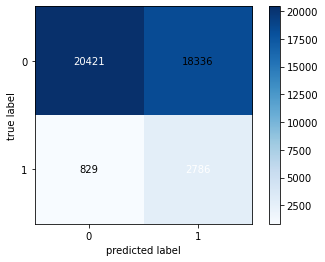

In [28]:
# ps_wide_clean = []
# ys_wide_clean = []
# ps_cnn_clean = []
# ps_widecnn_clean = []
ps_wide = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ps_testu_WIDE.csv', index_col = 0)
ys = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ys_testu.csv', index_col = 0)
# ps_cnn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ps_test_CNN.csv', index_col = 0)
# ps_widecnn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ps_test_WIDECNN.csv', index_col = 0)

# ps_wide_clean = clean(ps_wide)
# ys_clean = clean(ys)
# ps_cnn_clean = clean(ps_cnn)
# ps_widecnn_clean = clean(ps_widecnn)

cf_w = sklearn.metrics.confusion_matrix(ys,(ps_wide>0.04))
tn_w, fp_w, fn_w, tp_w = confusion_matrix(ys,(ps_wide>0.04)).ravel()
print("SENSITIVITY =", 100*tp/(tp+fn))
print("SPECIFICITY =", 100*tn/(tn+fp))
plt.figure(1)
plot_confusion_matrix(conf_mat = cf_w, colorbar = 1)

